In [1]:
import torch
import torch.nn.functional as F
from scorefield.models.ddpm.denoising_diffusion import Unet
from scorefield.models.ddpm.denoising_diffusion_1d import Unet1D, GaussianDiffusion1D, Dataset1D, Trainer1D
from scorefield.models.ddpm.gaussian_diffusion import Diffusion
from scorefield.utils.rendering import Maze2dRenderer
from scorefield.utils.rl_utils import load_config
from scorefield.utils.utils import log_num_check, imshow, gen_goals, random_batch
from scorefield.utils.diffusion_utils import bilinear_interpolate, compute_positions_based_on_time
from tqdm import tqdm


/home/junwoo/anaconda3/envs/scorefield/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No module named 'flow'
No module named 'carla'
pybullet build time: May 20 2022 19:44:17


/home/junwoo/anaconda3/envs/scorefield/lib/python3.8/site-packages/gym/utils/seeding.py:38: DeprecationWarning: WARN: Function `rng.randn(*size)` is marked as deprecated and will be removed in the future. Please use `rng.standard_normal(size)` instead.
  deprecation(
/home/junwoo/scorefield/scorefield/utils/rendering.py:29: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  img = np.fromstring(img_as_string, dtype='uint8').reshape((height, width, 4))[:,:,:3]


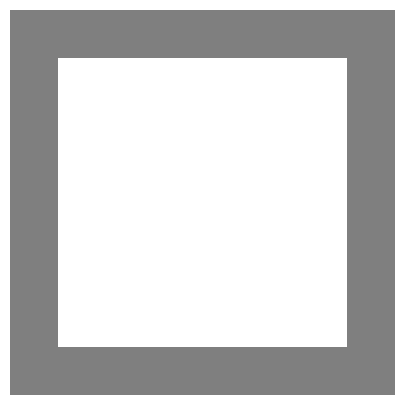

In [2]:
# Args
sac_config_dir = "/home/junwoo/scorefield/scorefield/configs/sac_args.yaml"
args = load_config(sac_config_dir)
device = 'cuda'

renderer = Maze2dRenderer(args)
env = renderer.env

log_path = args['log_path'] + 'tb/' + args['env_name']

env.reset()
map_img = renderer.map_init()

In [3]:
class Unet2D(Unet):
    def __init__(
        self, 
        dim, 
        out_dim, 
        dim_mults=(1, 2, 4, 8)
    ):
        super().__init__(dim=dim, out_dim=out_dim, dim_mults=dim_mults)
        
    def forward(self, obs, x, t):
        score_map = super().forward(obs, t)
        score = bilinear_interpolate(score_map, x)    # output: (B,2)
        return score
    
model = Unet2D(
    dim=args['image_size'],
    out_dim = 2,
    dim_mults = (1, 2, 4, 8),
).to(device)

# diffusion = GaussianDiffusion1D(
#     model,
#     seq_length=2,
#     timesteps=1000,
#     objective='pred_noise', # or pred_x0, pred_v
#     beta_schedule='linear', # or cosine
# ).to(device)

diffusion = Diffusion((2,))

optim = torch.optim.Adam(params=model.parameters(), lr=1e-3)

In [4]:
epochs = 1000
batch_size = 32

for iters in range(epochs):
    obs, goals = random_batch(renderer, map_img, batch_size)
    obs = torch.tensor(obs, dtype=torch.float32).to(device)
    goals = torch.tensor(goals).to(device)
    t = diffusion.sample_timesteps(batch_size).to(device)
    
    x_t = diffusion.noise_goal(goals, t).to(device)
    target_score = -(x_t - goals)  # It has to be divided by sigma^2, but sigma=1 in this case
    predicted_score = model(obs, x_t, t)
        
    loss = F.mse_loss(predicted_score, target_score)
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if iters % 10 == 0:
        print(f"iter {iters}: {loss.item()}")
    
    

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)